# Capstone Project - H&M Recommendation

Ana Berta Vegas; Ester Iglesias; Raquel Dominguez

## Model

En aquest notebook presentem el model final del projecte. 

Recordem que l'objectiu del model és recomanar productes de H&M als seus clients. És a dir, donat un conjunt d'observacions usuari-article, proporcionar un ranking adequat per cada usuari.

Per fer-ho, utilitzarem la llibreria de **TensorFlow Recommenders (TFRS)**, que permet crear models de sistemes de recomanació. 

En general, els sistemes de recomanació consten de dues fases:
1. *Retrieval Stage*: en aquesta etapa es crea un model amb el qual s'obté un conjunt inicial de centenars de candidats, d'entre tots els candidats possibles. L'objectiu principal del model és eliminar de manera eficient tots els candidats pels quals l'usuari no estigui interessat.

    Els *Retrieval Models* normalment consten de dos sub-models: *Query Model*: per les dades de consulta i *Candidate Model*: per les dades candidates. 
    
    Per implementar-ho, utilitzarem els mòduls de TensorFlow següents: tfrs.tasks.Retrieval i tfrs.metrics.FactorizedTopK



2. *Ranking Stage*: en aquesta etapa s'analitzen les sortides del Retrieval Model i s'afinen per seleccionar el millor conjunt de recomanacions. És a dir, l'objectiu principal d'aquesta fase és reduir el conjunt d'elements que poden interessar a l'usuari.

    En aquest cas, per recuperar els millors candidats d'una consulta determinada, utilitzarem la llibreria de TensorFlow ScaNN. En concret, per cada usuari, recuperarem 12 etiquetes, que es corresponen als articles previstos que un client pot comprar en els següents 7 dies.



En primer lloc, importem les llibreries necessàries per la creació del model:

In [1]:
#!pip install -q tensorflow-recommenders
#!pip install -q scann

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

from pathlib import Path
from typing import Dict, Text
import matplotlib.pyplot as plt

###  Datasets

**Transactions Dataset**

Llegim el dataset de transaccions i el preparem pel model:

In [3]:
transactions = pd.read_csv('transactions_train_model.csv')
transactions.shape

(28813419, 5)

In [4]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
28813414,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
28813415,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
28813416,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
28813417,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.1+ GB


Observem que la variable que ens interessa *article_id* és de tipus numèrica, pel que la modifiquem a string:

In [6]:
transactions['article_id'] = transactions['article_id'].astype(str)

A més, per tal d'unificar la nomenclatura de tots els *article_id*, afegim 0 inicials quan calgui, amb l'objectiu de tenir sempre el mateix número de caràcters:

In [7]:
transactions['article_id'] = transactions['article_id'].apply(lambda x: x.zfill(10))

Per motius de capacitat, ens quedem amb un "sample" del dataset, en aquest cas, l'últim any.

In [8]:
transactions = transactions[transactions['t_dat'] >='2019-09-22']

Dividim ara, el dataset entre els conjunts de train i test. En un sistema de recomanació, una bona manera de dividir-lo és en un moment indicat T. És a dir, les dades fins al moment T s'utilitzen per prediure les següents observacions.

En el nostre cas, agafarem les dades de l'últim mes com a dades de test i tota la resta d'observacions constituiran el dataset de train. En particular, tenim que *T=2020-09-01*.

In [9]:
transactions_train = transactions[transactions['t_dat'] <='2020-09-01']

In [10]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
15249344,2019-09-22,000fb6e772c5d0023892065e659963da90b1866035558e...,0695632095,0.033881,2
15249345,2019-09-22,0014b19aa47d031d859ae8d8f776524cdd35349db69d64...,0787648001,0.016932,2
15249346,2019-09-22,0023f9e96ae935c11bc2c950f317b73facea404dde95a3...,0767496001,0.015237,1
15249347,2019-09-22,0023f9e96ae935c11bc2c950f317b73facea404dde95a3...,0766826002,0.050831,1
15249348,2019-09-22,0023f9e96ae935c11bc2c950f317b73facea404dde95a3...,0655710010,0.050831,1


In [11]:
transactions_test = transactions[transactions['t_dat'] >'2020-09-01']

In [12]:
transactions_test.head()

,t_dat,customer_id,article_id,price,sales_channel_id
28120967,2020-09-02,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001,0.016932,1
28120968,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,0882354001,0.015237,2
28120969,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,0817354001,0.025407,2
28120970,2020-09-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0899002003,0.010153,1
28120971,2020-09-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0862482007,0.010153,1


**Customers Dataset**

Llegim el dataset de customers:

In [13]:
df_customer = pd.read_csv('customers_model.csv')
df_customer.shape

(1371980, 7)

In [14]:
df_customer

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,none,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,none,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,none,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,none,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,ACTIVE,none,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,ACTIVE,none,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


**Articles Dataset**

Llegim el dataset d'articles:

In [15]:
df_article = pd.read_csv('articles_model.csv')

In [16]:
df_article.head()

,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,108775015,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002
1,108775044,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002
2,108775051,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002
3,110065001,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017
4,110065002,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017


De la mateixa manera que hem fet al dataset de transactions, tractem la variable *article_id*:

In [17]:
df_article['article_id'] = df_article['article_id'].astype(str)
df_article['article_id'] = df_article['article_id'].apply(lambda x: x.zfill(10))

In [18]:
df_article.head()

,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0108775015,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002
1,0108775044,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002
2,0108775051,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002
3,0110065001,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017
4,0110065002,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017


A continuació, busquem els clients i els articles únics presents a les dades. És important que tant els clients com els articles siguin únics perquè necessitem mapejar els valors de les variables categòriques per després utilitzarles en el nostre model. És a dir, necessitem un diccionari d'aquestes dues varibles per crear el nostre model.

In [19]:
unic_customer_id = df_customer.customer_id.unique()
unic_article_id = df_article.article_id.unique()

In [20]:
unic_customer_id

array(['00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
       '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa',
       '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318',
       ...,
       'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264',
       'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a',
       'ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241'],
      dtype=object)

In [21]:
unic_article_id

array(['0108775015', '0108775044', '0108775051', ..., '0956217002',
       '0957375001', '0959461001'], dtype=object)

Creem el diccionari mencionat anteriorment:

In [22]:
article_slices = tf.data.Dataset.from_tensor_slices(dict(df_article[['article_id']]))

In [23]:
articles = article_slices.map(lambda x: x['article_id'])

In [24]:
articles

<MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

# H&M model 

## Retrieval Stage

Amb les dades ja preparades, creem el model. L'arquitectura d'aquest model és clau. Com hem mencionat anteriorment, utilitzarem un *Retrieval Model* constituit per dos sub-models. Així doncs, podem crear cada model per separat (*Query Model* i *Candidate Model*) i després combinar-los en un model final.

La idea principal és el que es representa a la figura següent:

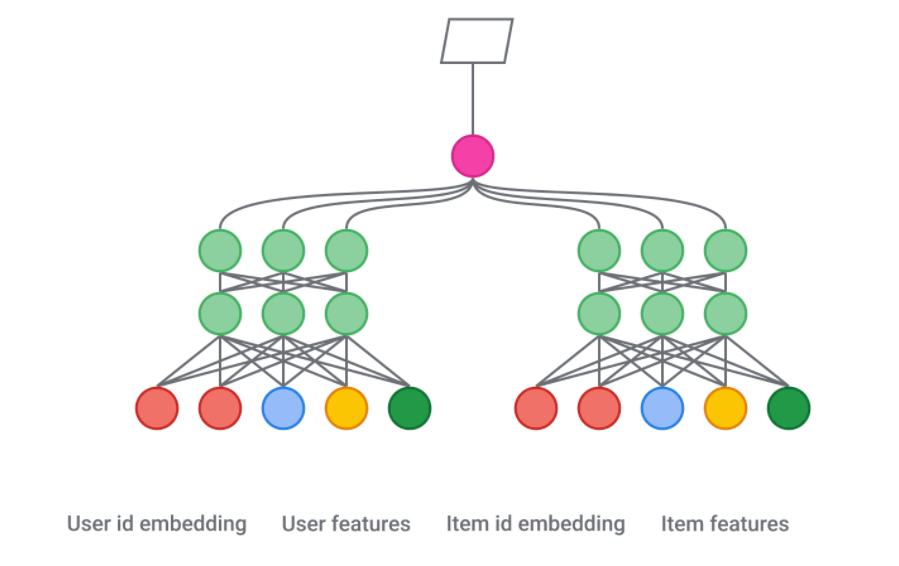

En particular, pel nostre cas:

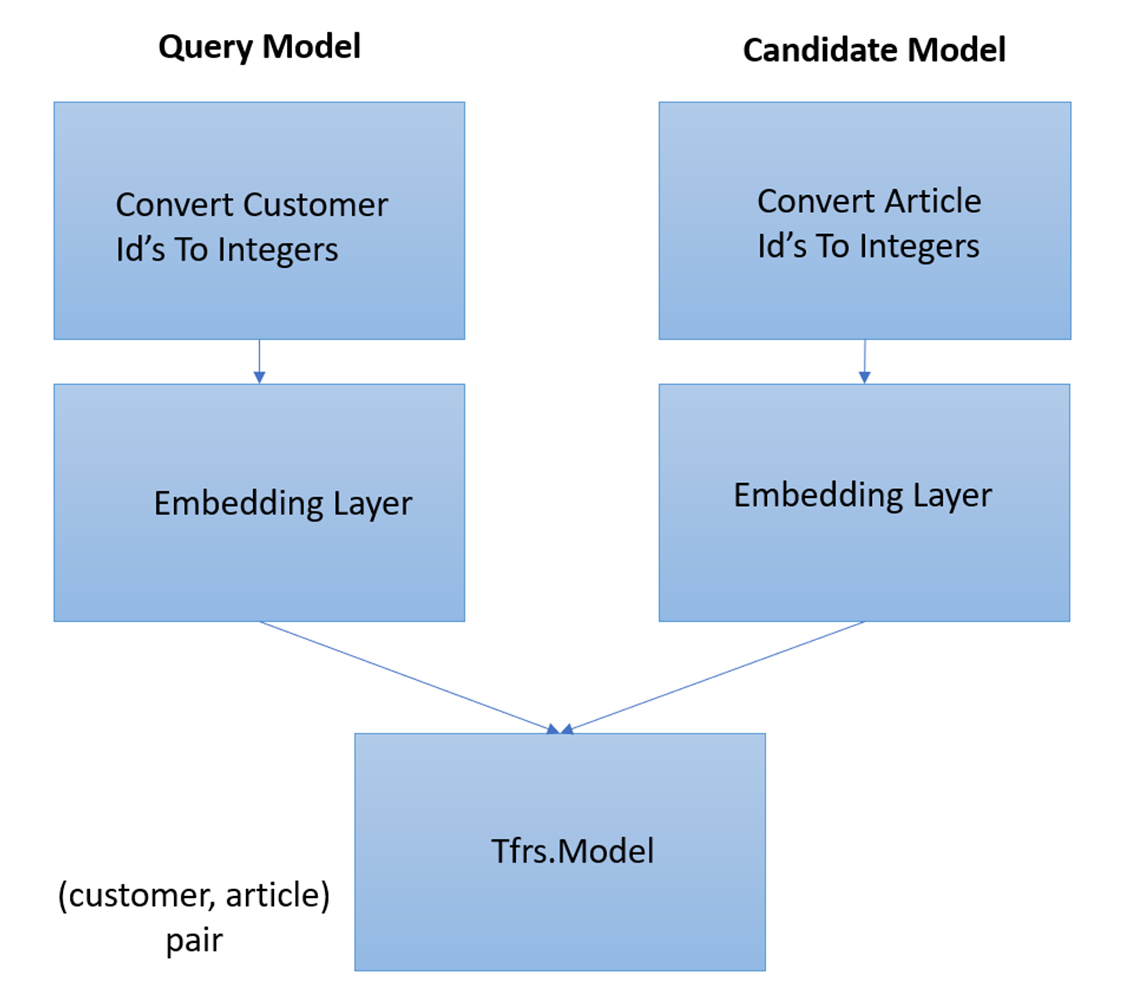

En primer lloc, fixem la dimensió de l'embedding:

In [25]:
embedding_dimension = 64

### Query Model

Definim ara el *Query Model*. Per crear-lo, utilitzem les capes de preprocessament de Keras, que ens permet convertir els ID dels clients en números enters. Després, mitjançant la capa d'embedding, es converteixen en embeddings d'usuaris. 

Utilitzarem la llista d'ID d'usuaris únics que hem calculat anteriorment:

In [26]:
customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unic_customer_id, mask_token=None),  
  tf.keras.layers.Embedding(len(unic_customer_id) + 1, embedding_dimension)
])

### Candidate Model

A continuació definim el *Candidate Model*. Seguim exactament el mateix procés que el del *Query Model*, però utilitzant ara la llista d'ID d'articles únics:

In [27]:
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unic_article_id, mask_token=None),
  tf.keras.layers.Embedding(len(unic_article_id) + 1, embedding_dimension)
])

### Model

A continuació, unifiquem els dos models. TensorFlow Recommenders exposa una classe de model base (tfrs.models.Model) que facilita la creació dels models. El que cal fer és configurar els components en el mètode *init* i implementar el métode *compute_loss*, agafant les caracterísitiques sense processar i tornant un valor de pèrdua.

El model base s'encarrega de crear el cicle d'entrenament apropiat per tal que s'ajusti al nostre model.

In [28]:
class RetrivalModel(tfrs.Model):
    
    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model),            
            ),
        )        

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
    
        customer_embeddings = self.customer_model(features["customer_id"])    
        article_embeddings = self.article_model(features["article_id"])

        # Task calcula la pèrdua i les mètriques
        return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

## Fitting i avaluació

Finalment, amb el model ja definit, podem ajustar i avaluar el model utilitzant les crides estàndard de Keras:

In [29]:
model = RetrivalModel(customer_model, article_model)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Apliquem *shuffle*, *batch* i *cache* en els conjunts definits anteriorment de test i train:

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices(dict(transactions[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(transactions_test[['customer_id','article_id']])).batch(256).cache()

### Entrenament

A continuació, entrenem el model. Utilizarem 5 iteracions per fer-ho:

In [32]:
num_epochs = 5

In [33]:
history = model.fit(
    train_ds,    
    epochs=num_epochs,
    verbose=1)

Epoch 1/5
52985/52985 [==============================] - 446s 8ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1268.9260 - regularization_loss: 0.0000e+00 - total_loss: 1268.9260
Epoch 2/5
52985/52985 [==============================] - 275s 5ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1021.0078 - regularization_loss: 0.0000e+00 - total_loss: 1021.0078
Epoch 3/5
52985/52985 [==============================] - 281s 5ms/step - factorized_top_k/top_1_categorical_accuracy: 

### Evaluamos el modelo

Finalment, avaluem el model entrenat al nostre conjunt de test:

In [34]:
model.evaluate(test_ds, return_dict=True)

2705/2705 [==============================] - 2424s 896ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0414 - factorized_top_k/top_5_categorical_accuracy: 0.1413 - factorized_top_k/top_10_categorical_accuracy: 0.1970 - factorized_top_k/top_50_categorical_accuracy: 0.3557 - factorized_top_k/top_100_categorical_accuracy: 0.4355 - loss: 821.2526 - regularization_loss: 0.0000e+00 - total_loss: 821.2526


{'factorized_top_k/top_1_categorical_accuracy': 0.04139203950762749,
 'factorized_top_k/top_5_categorical_accuracy': 0.14129787683486938,
 'factorized_top_k/top_10_categorical_accuracy': 0.19698983430862427,
 'factorized_top_k/top_50_categorical_accuracy': 0.35567954182624817,
 'factorized_top_k/top_100_categorical_accuracy': 0.43548721075057983,
 'loss': 723.0763549804688,
 'regularization_loss': 0,
 'total_loss': 723.0763549804688}

## Ranking Stage

Per afinar el nombre de recomanacions, utilizem ScaNN:

In [35]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.customer_model, k = 12 )
scann_index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(100), articles.batch(100).map(model.article_model)))
)

## Entregable

Llegim el dataset del entregable de exemple.

In [36]:
sample_submission = pd.read_csv('sample_submission.csv')

In [37]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...


Utilitzem la libreria *scann* per exportar el index de *retrival* aproximat per les prediccions. Això fara posible que surgeixin de manera eficient recomendacions de conjunts molts candidats.

In [38]:
_,articles = scann_index(sample_submission.customer_id.values) 

In [39]:
_,articles

(<tf.Tensor: shape=(1371980, 12), dtype=float32, numpy=
 array([[8.271187 , 8.070302 , 8.069231 , ..., 6.663306 , 6.6030912,
         6.594469 ],
        [6.1921673, 5.8434997, 5.581999 , ..., 5.1586165, 5.146164 ,
         5.0465446],
        [7.0383844, 6.934312 , 6.609849 , ..., 6.254777 , 6.235985 ,
         6.199253 ],
        ...,
        [7.975572 , 7.6712637, 7.0452585, ..., 6.627921 , 6.58377  ,
         6.558365 ],
        [7.058807 , 6.9507675, 6.8701944, ..., 6.583315 , 6.519717 ,
         6.5146933],
        [6.800028 , 5.251999 , 4.903334 , ..., 4.4552927, 4.4142175,
         4.3789206]], dtype=float32)>,
 <tf.Tensor: shape=(1371980, 12), dtype=string, numpy=
 array([[b'0884174002', b'0818036002', b'0826508001', ..., b'0921226002',
         b'0771970008', b'0841260003'],
        [b'0833499006', b'0811835005', b'0843872006', ..., b'0833499002',
         b'0882759003', b'0599580074'],
        [b'0727808001', b'0378124009', b'0727808007', ..., b'0727808002',
         b'06979

In [40]:
articles

<tf.Tensor: shape=(1371980, 12), dtype=string, numpy=
array([[b'0884174002', b'0818036002', b'0826508001', ..., b'0921226002',
        b'0771970008', b'0841260003'],
       [b'0833499006', b'0811835005', b'0843872006', ..., b'0833499002',
        b'0882759003', b'0599580074'],
       [b'0727808001', b'0378124009', b'0727808007', ..., b'0727808002',
        b'0697920010', b'0685601036'],
       ...,
       [b'0777714001', b'0615959005', b'0717171001', ..., b'0748202006',
        b'0792782001', b'0759462001'],
       [b'0882810003', b'0816587005', b'0835296001', ..., b'0880238003',
        b'0797079002', b'0821395003'],
       [b'0806050001', b'0869203003', b'0869203004', ..., b'0822090001',
        b'0904995001', b'0877090001']], dtype=object)>

Ara busquem les predicions calculades.

In [41]:
preds = articles.numpy().astype(str)

In [42]:
preds

array([['0884174002', '0818036002', '0826508001', ..., '0921226002',
        '0771970008', '0841260003'],
       ['0833499006', '0811835005', '0843872006', ..., '0833499002',
        '0882759003', '0599580074'],
       ['0727808001', '0378124009', '0727808007', ..., '0727808002',
        '0697920010', '0685601036'],
       ...,
       ['0777714001', '0615959005', '0717171001', ..., '0748202006',
        '0792782001', '0759462001'],
       ['0882810003', '0816587005', '0835296001', ..., '0880238003',
        '0797079002', '0821395003'],
       ['0806050001', '0869203003', '0869203004', ..., '0822090001',
        '0904995001', '0877090001']], dtype='<U10')

In [43]:
preds = pd.Series(map(' '.join, preds,))

In [44]:
preds

0          0884174002 0818036002 0826508001 0818032003 08...
1          0833499006 0811835005 0843872006 0687034024 08...
2          0727808001 0378124009 0727808007 0686564028 07...
3          0895804005 0873645001 0570189003 0720125001 07...
4          0589440005 0818320001 0902175001 0856405001 08...
                                 ...                        
1371975    0822344003 0791587007 0811500007 0757303015 08...
1371976    0779331008 0780172007 0681373016 0756522002 07...
1371977    0777714001 0615959005 0717171001 0863456002 07...
1371978    0882810003 0816587005 0835296001 0745232002 08...
1371979    0806050001 0869203003 0869203004 0745186001 08...
Length: 1371980, dtype: object

Finalment, al dataset de ejemple del entregable li afegeixo las prediccions que hem fet del seu *customer_id*.

In [45]:
sample_submission['prediction'] = preds

In [46]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0884174002 0818036002 0826508001 0818032003 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0833499006 0811835005 0843872006 0687034024 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0727808001 0378124009 0727808007 0686564028 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0895804005 0873645001 0570189003 0720125001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0589440005 0818320001 0902175001 0856405001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0822344003 0791587007 0811500007 0757303015 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0779331008 0780172007 0681373016 0756522002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0777714001 0615959005 0717171001 0863456002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0882810003 0816587005 0835296001 0745232002 08...


In [47]:
sample_submission.to_csv('submission.csv',index=False)

Per acabar, hem obtingut las 12 recomendaciones de articles para cada client. 